## Import packages and Load Data

In [77]:
import re
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_sentences(filename):
    sentences = []
    with open(filename, 'r', encoding='utf-8') as file:
        data = file.readlines()
        for d in data:
            if d.startswith('~'):
                d = d[1:].strip()
                tokens = d.split()
                sentences.append(tokens)
    return sentences

# Function to load human data from MaintNorm dataset
def load_maintnorm_sentences(file_path):
    dirty_sentences = []
    clean_sentences = []
    current_dirty = []
    current_clean = []
    pattern = r'[A-Za-z]{2}\d{4}-'
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if not line:  # Empty line means a new sentence
                if current_dirty and current_clean:
                    dirty_sentences.append(' '.join(current_dirty))
                    clean_sentences.append(' '.join(current_clean))
                    current_dirty = []
                    current_clean = []
            else:
                parts = line.split('\t')
                if len(parts) > 1:
                    dirty, clean = parts[0], parts[1]
                    if not clean in ['<id>', '-']:
                        dirty = re.sub(pattern, '', dirty)
                        current_dirty.append(dirty.lower().strip())
                    current_clean.append(clean.lower())
    return dirty_sentences, clean_sentences

# Synthetic data
before_tokens = load_sentences('../mwo_sentences/before_log.txt')
after_tokens = load_sentences('../mwo_sentences/after_log.txt')

with open('../TuringTest/Version1/synthetic_generate_v1.txt', 'r', encoding='utf-8') as file:
    turing1 = [line.strip() for line in file.readlines()]
    turing1_tokens = [line.split() for line in turing1]
    
with open('../TuringTest/Version2/synthetic_generate_v2.txt', 'r', encoding='utf-8') as file:
    turing2 = [line.strip() for line in file.readlines()]
    turing2_tokens = [line.split() for line in turing2]

with open('../mwo_sentences/synthetic.csv', 'r', encoding='utf-8') as file:
    syn = csv.reader(file)
    syn = [row[0] for row in syn]
    syn_tokens = [line.split() for line in syn]

# Human data
with open('../data/MaintIE/gold_release.json', 'r', encoding='utf-8') as file:
    gold_data = json.load(file)

with open('../data/MaintIE/silver_release.json', 'r', encoding='utf-8') as file:
    silver_data = json.load(file)

_, train_clean = load_maintnorm_sentences('../data/MaintNorm/train.norm')
_, test_clean = load_maintnorm_sentences('../data/MaintNorm/test.norm')
_, val_clean = load_maintnorm_sentences('../data/MaintNorm/val.norm')
maintnorm_data = list(set(train_clean + test_clean + val_clean)) # remove duplicates
maintnorm_tokens = [line.split() for line in maintnorm_data]

In [83]:
# Print number of tokens in the data
def sentence_tokens_analysis(data, data_name):
    """ Analyse the number of tokens in the maintie data. """
    min_tokens = 1000 # Minimum number of tokens
    max_tokens = 0    # Maximum number of tokens
    sum_tokens = 0    # Sum of tokens

    for tokens in data:
        if len(tokens) > max_tokens:
            max_tokens = len(tokens)
        if len(tokens) < min_tokens:
            min_tokens = len(tokens)
        sum_tokens += len(tokens)

    # Average number of tokens
    avg_tokens = round(sum_tokens / len(data), 2)
    
    df = pd.DataFrame({"Minimum": [min_tokens], 
                       "Maximum": [max_tokens], 
                       "Average": [avg_tokens]})
    print(f"{data_name} Tokens Count")
    print(df.to_string(index=False))
    print()
    return (min_tokens, max_tokens, avg_tokens)

# Print number of tokens in the maintie data
def maintie_tokens_analysis(maintie_data, data_name):
    """ Analyse the number of tokens in the maintie data. """
    min_tokens = 1000 # Minimum number of tokens
    max_tokens = 0    # Maximum number of tokens
    sum_tokens = 0    # Sum of tokens

    for data in maintie_data:
        tokens = data['tokens']
        if len(tokens) > max_tokens:
            max_tokens = len(tokens)
        if len(tokens) < min_tokens:
            min_tokens = len(tokens)
        sum_tokens += len(tokens)

    # Average number of tokens
    avg_tokens = round(sum_tokens / len(maintie_data), 2)
    
    df = pd.DataFrame({"Minimum": [min_tokens], 
                       "Maximum": [max_tokens], 
                       "Average": [avg_tokens]})
    print(f"{data_name} Tokens Count")
    print(df.to_string(index=False))
    print()
    return (min_tokens, max_tokens, avg_tokens)

def get_average_length(data):
    avg_min, avg_max, avg_avg = 0, 0, 0
    for d in data:
        avg_min += d[0]
        avg_max += d[1]
        avg_avg += d[2]
    avg_min /= len(data)
    avg_max /= len(data)
    avg_avg /= len(data)
    return (avg_min, avg_max, avg_avg)

# Print the number of tokens in the synthetic data
# before_lengths = synthetic_tokens_analysis(before_tokens, "Before Fixing")
# turing1_lengths = synthetic_tokens_analysis(turing1_tokens, "Turing Test V1")
after_lengths = sentence_tokens_analysis(after_tokens, "After Fixing")
turing2_lengths = sentence_tokens_analysis(turing2_tokens, "Turing Test V2")
syn_lengths = sentence_tokens_analysis(syn_tokens, "Synthetic Data")
maintnorm_lengths = sentence_tokens_analysis(maintnorm_tokens, "MaintNorm Clean")
gold_lengths = maintie_tokens_analysis(gold_data, "MaintIE Gold")
silver_lengths = maintie_tokens_analysis(silver_data, "MaintIE Silver")

# Average human and synthetic token distribution
print(f"Total human sentences pooled: {len(gold_data) + len(silver_data) + len(maintnorm_tokens)}")
print(f"Total synthetic sentences pooled: {len(after_tokens) + len(turing2_tokens) + len(syn_tokens)}")
human_lengths = get_average_length([gold_lengths, silver_lengths, maintnorm_lengths])
synthetic_lengths = get_average_length([after_lengths, turing2_lengths, syn_lengths])

After Fixing Tokens Count
 Minimum  Maximum  Average
       2       10      5.1

Turing Test V2 Tokens Count
 Minimum  Maximum  Average
       2        9     4.84

Synthetic Data Tokens Count
 Minimum  Maximum  Average
       2        9     4.88

MaintNorm Clean Tokens Count
 Minimum  Maximum  Average
       1       14     5.66

MaintIE Gold Tokens Count
 Minimum  Maximum  Average
       2       12     5.69

MaintIE Silver Tokens Count
 Minimum  Maximum  Average
       1       13     5.37

Total human sentences pooled: 17328
Total synthetic sentences pooled: 10477


## Token Distribution

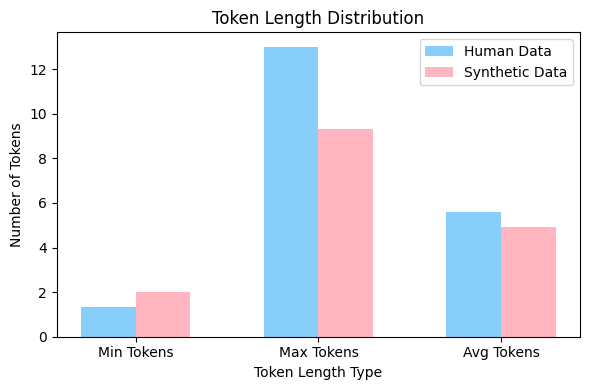

In [79]:
# Labels for the x-axis (min, max, avg)
labels = ['Min Tokens', 'Max Tokens', 'Avg Tokens']

# Set up the bar chart
x = np.arange(len(labels))  # The label locations
width = 0.3  # The width of the bars

fig, ax = plt.subplots(figsize=(6, 4))

# Plot each dataset's values with an offset to group them
human = ax.bar(x - width/2, human_lengths, width, label='Human Data', color='lightskyblue')
synthetic = ax.bar(x + width/2, synthetic_lengths, width, label='Synthetic Data', color='lightpink')

# Add labels, title, and legend
ax.set_xlabel('Token Length Type')
ax.set_ylabel('Number of Tokens')
ax.set_title('Token Length Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()